In [ ]:
import argparse
import os
import sys
import glob
import fnmatch
from functools import partial
import cv2
from cv2 import randn
import torch
import numpy as np
from torch import Tensor, FloatTensor, uint8
from omegaconf import OmegaConf
from PIL import Image
from PIL.Image import Resampling
from tqdm import tqdm, trange
from itertools import islice, repeat as repeat_, chain, pairwise
from einops import rearrange, repeat
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast, nn
from torch.nn import functional as F
from contextlib import contextmanager, nullcontext
from random import randint
from typing import Generic, Optional, Iterable, List, TypeAlias, Tuple, TypeVar, Callable, Protocol, TypedDict
from types import SimpleNamespace
import re
from ldm.models.diffusion.ddpm import LatentDiffusion
import abc
from dataclasses import dataclass
from enum import Enum
from transformers import logging

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from k_diffusion.sampling import sample_lms, sample_dpm_2, sample_dpm_2_ancestral, sample_euler, sample_euler_ancestral, sample_heun, sample_dpm_fast, sample_dpm_adaptive, get_sigmas_karras, append_zero
from k_diffusion.external import CompVisDenoiser

import matplotlib.pyplot as plt

# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
logging.set_verbosity_error()

def get_device():
	if(torch.cuda.is_available()):
		return 'cuda'
	elif(torch.backends.mps.is_available()):
		return 'mps'
	else:
		return 'cpu'

class KSamplerCallbackPayload(TypedDict):
	x: FloatTensor
	i: int
	sigma: FloatTensor
	sigma_hat: FloatTensor
	denoised: FloatTensor

KSamplerCallback: TypeAlias = Callable[[KSamplerCallbackPayload], None]

T = TypeVar('T')
Decorator: TypeAlias = Callable[[T], T]
TensorDecorator: TypeAlias = Decorator[Tensor]

class DiffusionModel(Protocol):
	scale_factor: float
	def __call__(self, x: Tensor, sigma: Tensor, **kwargs) -> Tensor: ...
	def decode_first_stage(self, latents: Tensor) -> Tensor: ...
	def encode_first_stage(self, pixels: Tensor) -> Tensor: ...
	def get_first_stage_encoding(self, encoded: Tensor) -> Tensor: ...

class DiffusionModelMixin(DiffusionModel):
	scale_factor: float
	inner_model: DiffusionModel

	@property
	def scale_factor(self) -> float:
		"""
		notionally this is the standard deviation of latent values encoded by the autoencoder,
		across the whole dataset upon which it learned.
		stable-diffusion just went with the standard deviation of the first batch:
		0.18215
		"""
		return self.inner_model.scale_factor

	def decode_first_stage(self, latents: Tensor) -> Tensor:
		return self.inner_model.decode_first_stage(latents)

	def encode_first_stage(self, pixels: Tensor) -> Tensor:
		return self.inner_model.encode_first_stage(pixels)

	def get_first_stage_encoding(self, encoded: Tensor) -> Tensor:
		return self.inner_model.get_first_stage_encoding(encoded)

class BaseModelWrapper(nn.Module, DiffusionModelMixin):
	inner_model: DiffusionModel

	def __init__(self, inner_model: DiffusionModel):
		super().__init__()
		self.inner_model = inner_model
		DiffusionModelMixin.__init__(self)

# workaround until k-diffusion introduces official base model wrapper,
# to make the wrapper forward all method calls to the wrapped model
# https://github.com/crowsonkb/k-diffusion/pull/23#issuecomment-1239937951

class CompVisDenoiserWrapper(CompVisDenoiser, DiffusionModelMixin):
	inner_model: DiffusionModel

	def __init__(self, model: DiffusionModel, quantize=False):
		CompVisDenoiser.__init__(self, model, quantize=quantize)
		DiffusionModelMixin.__init__(self)

# samplers from the Karras et al paper
PRE_KARRAS_K_DIFF_SAMPLERS = {'k_lms', 'dpm2_ancestral', 'euler_ancestral'}
KARRAS_SAMPLERS = {'heun', 'euler', 'dpm2'}
DPM_SOLVER_SAMPLERS = {'dpm_fast', 'dpm_adaptive'}
K_DIFF_SAMPLERS = {*KARRAS_SAMPLERS, *
				   PRE_KARRAS_K_DIFF_SAMPLERS, *DPM_SOLVER_SAMPLERS}
NOT_K_DIFF_SAMPLERS = {'ddim', 'plms'}
VALID_SAMPLERS = {*K_DIFF_SAMPLERS, *NOT_K_DIFF_SAMPLERS}

class KCFGDenoiser(BaseModelWrapper):
	def forward(
		self,
		x: Tensor,
		sigma: Tensor,
		uncond: Tensor,
		cond: Tensor,
		cond_scale: float,
		cond_arities: Iterable[int],
		cond_weights: Optional[Iterable[float]]
	) -> Tensor:
		if uncond is None or cond_scale == 1.0:
			assert cond is None or cond.size(
				dim=0) == 1, "multi-cond guidance only implemented when CFG is in-use; please pass in an uncond, or use no more than 1 cond"
			return self.inner_model(x, sigma, cond=cond)
		uncond_count = uncond.size(dim=0)
		cond_count = cond.size(dim=0)
		cond_in = torch.cat((uncond, cond))
		del uncond, cond
		cond_arities_tensor = torch.tensor(cond_arities, device=cond_in.device)
		x_in = cat_self_with_repeat_interleaved(
			t=x, factors_tensor=cond_arities_tensor, factors=cond_arities, output_size=cond_count)
		del x
		sigma_in = cat_self_with_repeat_interleaved(
			t=sigma, factors_tensor=cond_arities_tensor, factors=cond_arities, output_size=cond_count)
		del sigma
		uncond_out, conds_out = self.inner_model(
			x_in, sigma_in, cond=cond_in).split([uncond_count, cond_count])
		del x_in, sigma_in, cond_in
		unconds = repeat_interleave_along_dim_0(
			t=uncond_out, factors_tensor=cond_arities_tensor, factors=cond_arities, output_size=cond_count)
		del cond_arities_tensor
		# transform
		#   tensor([0.5, 0.1])
		# into:
		#   tensor([[[[0.5000]]],
		#           [[[0.1000]]]])
		weight_tensor = (torch.tensor(cond_weights, device=uncond_out.device,
						 dtype=unconds.dtype) * cond_scale).reshape(len(cond_weights), 1, 1, 1)
		deltas: Tensor = (conds_out-unconds) * weight_tensor
		del conds_out, unconds, weight_tensor
		cond = sum_along_slices_of_dim_0(deltas, arities=cond_arities)
		del deltas
		return uncond_out + cond

def chunk(it, size):
	it = iter(it)
	return iter(lambda: tuple(islice(it, size)), ())

@dataclass
class InBetweenParams(Generic[T]):
	from_: T
	to: T
	step: float

MakeInbetween: TypeAlias = Callable[[InBetweenParams], T]

def intersperse_linspace(
	lst: List[T],
	make_inbetween: MakeInbetween[T],
	steps: Optional[int]
) -> List[T]:
	if steps is None:
		return lst
	return [
		*chain(
			*(
				(
					pair[0],
					*(
						make_inbetween(
							InBetweenParams(
								from_=pair[0],
								to=pair[1],
								step=step
							)
						) for step in np.linspace(
							start=1/steps,
							stop=1,
							num=steps-1,
							endpoint=False
						)
					)
				) for pair in pairwise(lst)
			)
		),
		lst[-1]
	]

def numpy_to_pil(images):
	"""
	Convert a numpy image or a batch of images to a PIL image.
	"""
	if images.ndim == 3:
		images = images[None, ...]
	images = (images * 255).round().astype("uint8")
	pil_images = [Image.fromarray(image) for image in images]

	return pil_images

class LatentsToPils(Protocol):
	def __call__(x: Tensor) -> Tensor: List[Image.Image]

def make_latents_to_pils(model: LatentDiffusion) -> LatentsToPils:
	def latents_to_pils(latents: Tensor) -> List[Image.Image]:
		decoded: Tensor = model.decode_first_stage(latents)
		clamped: Tensor = torch.clamp((decoded + 1.0) / 2.0, min=0.0, max=1.0)
		del decoded
		rearranged: Tensor = rearrange(clamped, 'b c h w -> b h w c')
		del clamped
		denormalized: Tensor = 255. * rearranged
		del rearranged
		rgb_images = denormalized.cpu().to(dtype=uint8).numpy()
		del denormalized
		pils: List[Image.Image] = [Image.fromarray(
			rgb_image) for rgb_image in rgb_images]
		del rgb_images
		return pils
	return latents_to_pils

def repeat_along_dim_0(t: Tensor, factor: int) -> Tensor:
	"""
	Repeats a tensor's contents along its 0th dim `factor` times.

	repeat_along_dim_0(torch.tensor([[0,1]]), 2)
	tensor([[0, 1],
			[0, 1]])
	# shape changes from (1, 2)
	#                 to (2, 2)

	repeat_along_dim_0(torch.tensor([[0,1],[2,3]]), 2)
	tensor([[0, 1],
			[2, 3],
			[0, 1],
			[2, 3]])
	# shape changes from (2, 2)
	#                 to (4, 2)
	"""
	assert factor >= 1
	if factor == 1:
		return t
	if t.size(dim=0) == 1:
		# prefer expand() whenever we can, since doesn't copy
		return t.expand(factor * t.size(dim=0), *(-1,)*(t.ndim-1))
	return t.repeat((factor, *(1,)*(t.ndim-1)))

def repeat_interleave_along_dim_0(t: Tensor, factors: Iterable[int], factors_tensor: Tensor, output_size: int) -> Tensor:
	"""
	repeat_interleave()s a tensor's contents along its 0th dim.

	factors=(2,3)
	factors_tensor = torch.tensor(factors)
	output_size=factors_tensor.sum().item() # 5
	t=torch.tensor([[0,1],[2,3]])
	repeat_interleave_along_dim_0(t=t, factors=factors, factors_tensor=factors_tensor, output_size=output_size)
	tensor([[0, 1],
			[0, 1],
			[2, 3],
			[2, 3],
			[2, 3]])
	"""
	factors_len = len(factors)
	assert factors_len >= 1
	if len(factors) == 1:
		# prefer repeat() whenever we can, because MPS doesn't support repeat_interleave()
		return repeat_along_dim_0(t, factors[0])
	if t.device.type != 'mps':
		return t.repeat_interleave(factors_tensor, dim=0, output_size=output_size)
	return torch.cat([repeat_along_dim_0(split, factor) for split, factor in zip(t.split(1, dim=0), factors)])

def cat_self_with_repeat_interleaved(t: Tensor, factors: Iterable[int], factors_tensor: Tensor, output_size: int) -> Tensor:
	"""
	Fast-paths for a pattern which in its worst-case looks like:
	t=torch.tensor([[0,1],[2,3]])
	factors=(2,3)
	torch.cat((t, t.repeat_interleave(factors, dim=0)))
	tensor([[0, 1],
			[2, 3],
			[0, 1],
			[0, 1],
			[2, 3],
			[2, 3],
			[2, 3]])

	Fast-path:
	  `len(factors) == 1`
	  it's just a normal repeat
	t=torch.tensor([[0,1]])
	factors=(2)
	tensor([[0, 1],
			[0, 1],
			[0, 1]])

	t=torch.tensor([[0,1],[2,3]])
	factors=(2)
	tensor([[0, 1],
			[2, 3],
			[0, 1],
			[2, 3],
			[0, 1],
			[2, 3]])
	"""
	if len(factors) == 1:
		return repeat_along_dim_0(t, factors[0]+1)
	return torch.cat((t, repeat_interleave_along_dim_0(t=t, factors_tensor=factors_tensor, factors=factors, output_size=output_size)))

def sum_along_slices_of_dim_0(t: Tensor, arities: Iterable[int]) -> Tensor:
	"""
	Implements fast-path for a pattern which in the worst-case looks like this:
	t=torch.tensor([[1],[2],[3]])
	arities=(2,1)
	torch.cat([torch.sum(split, dim=0, keepdim=True) for split in t.split(arities)])
	tensor([[3],
			[3]])

	Fast-path:
	  `len(arities) == 1`
	  it's just a normal sum(t, dim=0, keepdim=True)
	t=torch.tensor([[1],[2]])
	arities=(2)
	t.sum(dim=0, keepdim=True)
	tensor([[3]])
	"""
	if len(arities) == 1:
		if t.size(dim=0) == 1:
			return t
		return t.sum(dim=0, keepdim=True)
	splits: List[Tensor] = t.split(arities)
	del t
	sums: List[Tensor] = [
		torch.sum(split, dim=0, keepdim=True) for split in splits]
	del splits
	return torch.cat(sums)

def load_model_from_config(config, ckpt, verbose=False):
	print(f"Loading model from {ckpt}")
	pl_sd = torch.load(ckpt, map_location="cpu")
	if "global_step" in pl_sd:
		print(f"Global Step: {pl_sd['global_step']}")
	sd = pl_sd["state_dict"]
	model = instantiate_from_config(config.model)
	m, u = model.load_state_dict(sd, strict=False)
	if len(m) > 0 and verbose:
		print("missing keys:")
		print(m)
	if len(u) > 0 and verbose:
		print("unexpected keys:")
		print(u)

	model.to(get_device())
	model.eval()
	return model

def check_safety_poorly(images, **kwargs):
	return images, False

# https://github.com/lucidrains/imagen-pytorch/blob/ceb23d62ecf611082c82b94f2625d78084738ced/imagen_pytorch/imagen_pytorch.py#L127
# from lucidrains' imagen_pytorch
# MIT-licensed
def right_pad_dims_to(x: Tensor, t: Tensor) -> Tensor:
	padding_dims = x.ndim - t.ndim
	if padding_dims <= 0:
		return t
	return t.view(*t.shape, *((1,) * padding_dims))

def load_img(path):
	image = Image.open(path).convert("RGB")
	w, h = image.size
	print(f"loaded input image of size ({w}, {h}) from {path}")
	# resize to integer multiple of 32
	w, h = map(lambda x: x - x % 32, (w, h))
	image = image.resize((w, h), resample=Resampling.LANCZOS)
	image = np.array(image).astype(np.float32) / 255.0
	image = image[None].transpose(0, 3, 1, 2)
	image = torch.from_numpy(image)
	return 2.*image - 1.

# the idea of "ending the noise ramp early" (i.e. setting a high sigma_min) is that sigmas as lower as sigma_min
# aren't very impactful, and every sigma counts when our step count is low
# https://github.com/crowsonkb/k-diffusion/pull/23#issuecomment-1234872495
# this is just a more performant way to get the "sigma before sigma_min" from a noise schedule, aka
# get_sigmas_karras(n=steps, sigma_max=sigma_max, sigma_min=sigma_min_nominal, rho=rho)[-3]
def get_premature_sigma_min(
	steps: int,
	sigma_max: float,
	sigma_min_nominal: float,
	rho: float
) -> float:
	min_inv_rho = sigma_min_nominal ** (1 / rho)
	max_inv_rho = sigma_max ** (1 / rho)
	ramp = (steps-2) * 1/(steps-1)
	sigma_min = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho)) ** rho
	return sigma_min

@dataclass
class WeightedPrompt():
	text: str
	weight: float

def parse_prompt(prompt: str) -> WeightedPrompt:
	match = re.search(r"^-?\d+(\.\d*)?:", prompt)
	if match is None:
		return WeightedPrompt(text=prompt, weight=1.0)
	group = match.group()[:-1]
	weight = float(group)
	return WeightedPrompt(text=prompt[len(group)+1:], weight=weight)

MultiPrompt: TypeAlias = Iterable[WeightedPrompt]

@dataclass
class SampleSpec(abc.ABC):
	multiprompt: MultiPrompt

# https://stackoverflow.com/a/73107990/5257399
class InterpStrategy(str, Enum):
	CondDiff = 'cond_diff'
	LatentSlerp = 'slerp'
	LatentLerp = 'lerp'

	def __str__(self) -> str:
		return self.value

@dataclass
class BetweenSampleSpec(SampleSpec):
	target_multiprompt: MultiPrompt
	interp_quotient: float

SampleSpec.register(BetweenSampleSpec)

@dataclass
class IdenticalSamplesBatchSpec():
	sample: SampleSpec

@dataclass
class VariedSamplesBatchSpec():
	samples: List[SampleSpec]

@dataclass
class BatchSpec(abc.ABC):
	pass

BatchSpec.register(IdenticalSamplesBatchSpec)
BatchSpec.register(VariedSamplesBatchSpec)

load_opt = SimpleNamespace(
	laion400m=None,
	config='../configs/stable-diffusion/v1-inference.yaml',
	ckpt='../models/ldm/stable-diffusion-v1/model.ckpt',
	embedding_path=None,
)

if load_opt.laion400m:
	print("Falling back to LAION 400M model...")
	load_opt.config = "../configs/latent-diffusion/txt2img-1p4B-eval.yaml"
	load_opt.ckpt = "../models/ldm/text2img-large/model.ckpt"

config = OmegaConf.load(f"{load_opt.config}")
model: LatentDiffusion = load_model_from_config(config, f"{load_opt.ckpt}")
if load_opt.embedding_path is not None:
	model.embedding_manager.load(load_opt.embedding_path)

device = torch.device(get_device())
model = model.to(device)

Global seed set to 1527468831


sigmas (before quantization):
[14.6146, 8.5600, 4.7965, 2.5508, 1.2741, 0.5895, 0.2480, 0.0923, 0.0000]
sigmas (after quantization):
[14.6146, 8.5700, 4.7975, 2.5482, 1.2721, 0.5884, 0.2482, 0.0936, 0.0000]


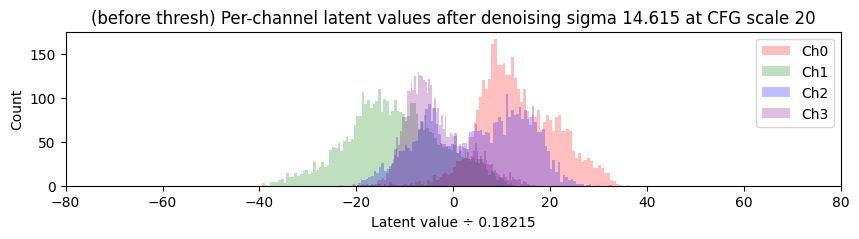

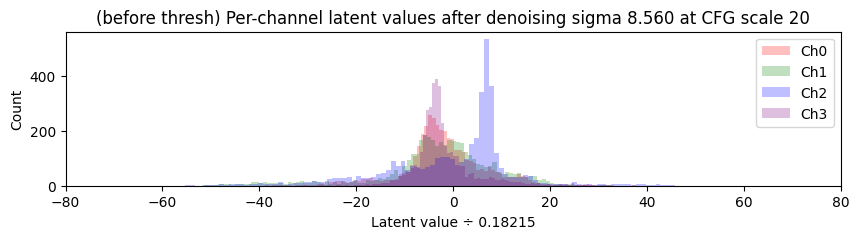

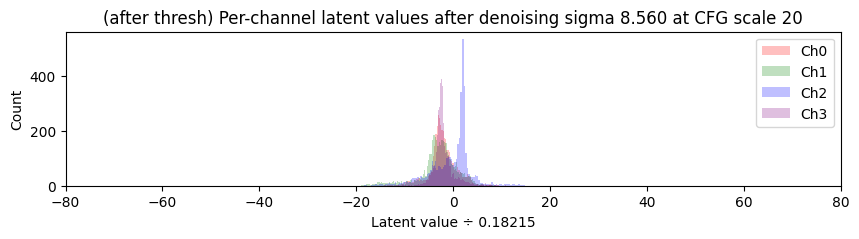

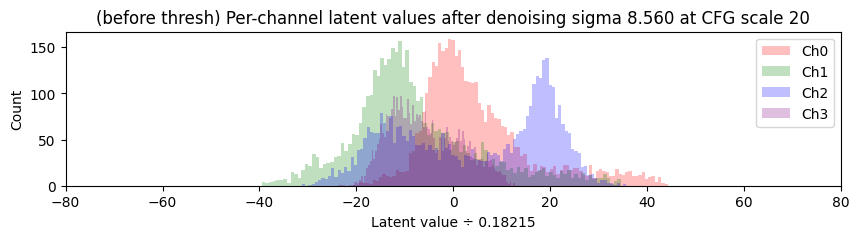

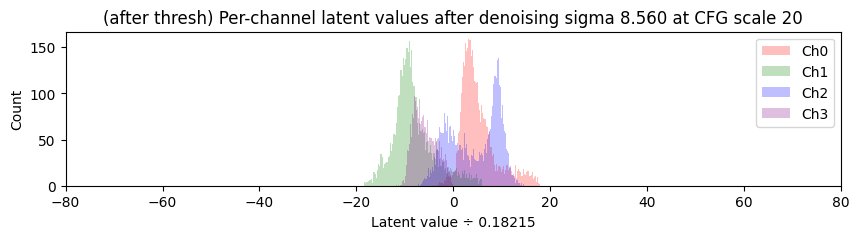

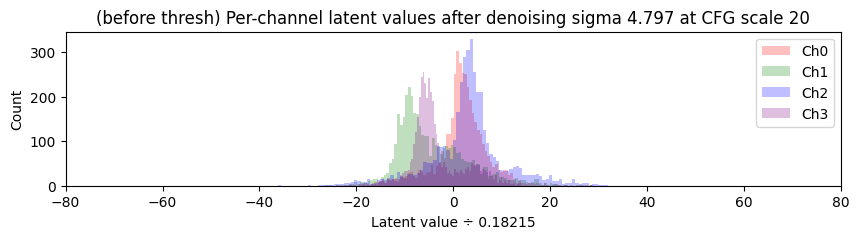

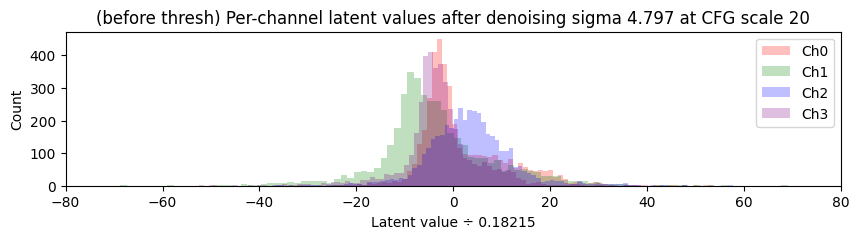

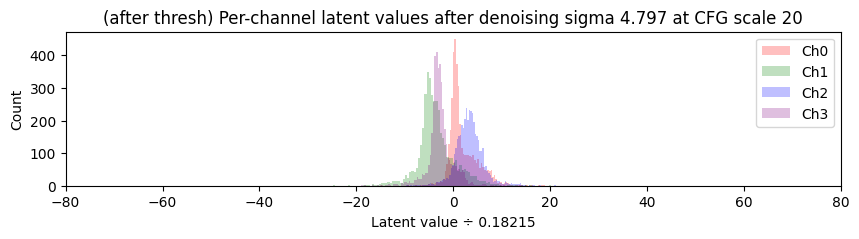

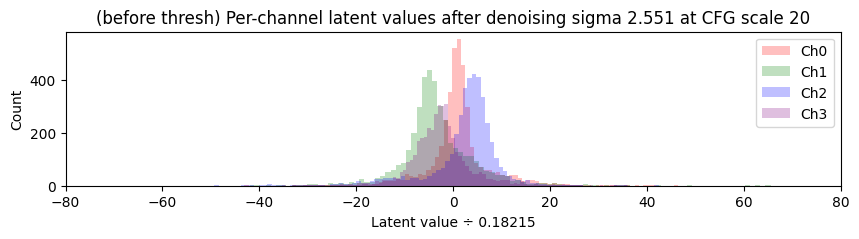

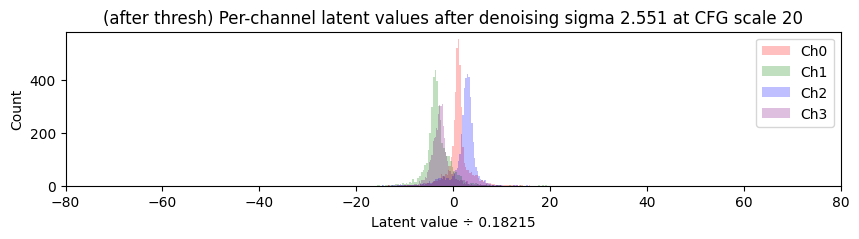

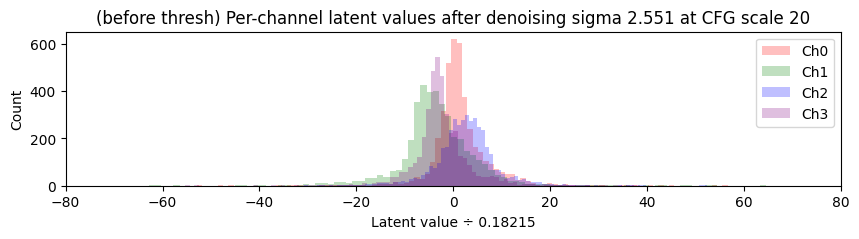

KeyboardInterrupt: 

In [33]:
def dynamic_threshold(percentile: float, floor: float, t: Tensor) -> Tensor:
	r"""
	Args:
		percentile: float between 0.0 and 1.0. for example 0.995 would subject only the top 0.5%ile to clamping.
		t: [b, c, v] tensor in pixel or latent space (where v is the result of flattening w and h)
	"""
	a = t.abs()
	q = torch.quantile(a, percentile, dim=2)
	q.clamp_(min=floor)
	q = q.unsqueeze(2).expand(*t.shape)
	t = t.clamp(-q, q)
	t = t / q
	return t

cfg_scale=20.0

def graph_common() -> None:
	plt.figure(figsize=(10,2))
	plt.ylabel('Count')
	plt.xlabel('Latent value ÷ 0.18215')

def graph_each_latent(unscaled_flattened_sample: Tensor, sigma: float, addendum: str) -> None:
	chs = [torch.histogram(c) for c in unscaled_flattened_sample]
	graph_common()
	plt.title('%sPer-channel latent values after denoising sigma %.3f at CFG scale %d' % (addendum, sigma, cfg_scale))
	for ch, col in zip(chs, ('red','green','blue','purple',)):
		plt.hist(ch.bin_edges[:-1].cpu(), ch.bin_edges.cpu(), weights=ch.hist.cpu(), color = col, alpha = 0.25)
	plt.xlim(-40, 40)
	# plt.ylim(0, 800)
	# plt.xlim(-20, 20)
	# plt.ylim(0, 200)
	# plt.yscale("log", base=2)
	plt.legend(['Ch0','Ch1','Ch2','Ch3'])
	plt.show()

def graph_overall(unscaled_flattened_sample: Tensor, sigma: float) -> None:
	h = torch.histogram(unscaled_flattened_sample)
	graph_common()
	plt.title('Global latent values after denoising sigma %.3f at CFG scale %d' % (sigma, cfg_scale))
	plt.hist(h.bin_edges[:-1].cpu(), h.bin_edges.cpu(), weights=h.hist.cpu())
	plt.legend(['All'])
	plt.show()


class DynamicThresholdingDenoiser(BaseModelWrapper):
	apply_threshold: TensorDecorator
	floor: float
	ceil: float

	def __init__(self, model: DiffusionModel, percentile: float, floor: float, ceil: float):
		super().__init__(model)
		self.apply_threshold = partial(dynamic_threshold, percentile, floor)
		self.floor = floor
		self.ceil = ceil

	def forward(
		self,
		x: FloatTensor,
		sigma: FloatTensor,
		cond: FloatTensor,
		**kwargs,
	) -> FloatTensor:
		# thanks to @marunine for explaining how to apply dynamic thresholding to scaled latents
		latents: FloatTensor = self.inner_model(x, sigma, cond=cond, **kwargs)
		unscaled: Tensor = latents / self.scale_factor
		graph_each_latent(unscaled[0], sigma.item(), '(before thresh) ')
		flattened: Tensor = unscaled.flatten(2)
		means: Tensor = flattened.mean(dim=2).unsqueeze(2)
		recentered: Tensor = flattened-means
		magnitudes: Tensor = recentered.abs().max()
		if magnitudes.lt(torch.tensor(self.ceil, device=magnitudes.device)).all().item():
			return latents
		normalized: Tensor = recentered/magnitudes
		thresholded: Tensor = self.apply_threshold(normalized)
		denormalized: Tensor = thresholded*magnitudes
		uncentered: Tensor = denormalized+means
		graph_each_latent(uncentered[0], sigma.item(), '(after thresh) ')
		unflattened: Tensor = uncentered.unflatten(2, latents.shape[2:])
		scaled = unflattened * self.scale_factor
		return scaled

opt = SimpleNamespace(
	**load_opt.__dict__,
	prompt=[['masterpiece character portrait of shrine maiden, artgerm, ilya kuvshinov, tony pyykko, from side, looking at viewer, long black hair, upper body, 4k hdr, global illumination, lit from behind, oriental scenic, Pixiv featured, vaporwave']],
	prompt_interpolation_steps=None,
	prompt_interpolation_strategy=InterpStrategy.CondDiff,
	outdir='../outputs/txt2img-samples',
	skip_grid=True,
	skip_save=None,
	steps=8,
	sampler='heun',
	karras_noise=True,
	end_noise_ramp_early=True,
	sigma_max=None,
	sigma_min=None,
	rho=7.,
	churn=0.,
	dynamic_thresholding=True,
	dynamic_thresholding_percentile=0.9995,#0.9,
	# actually it runs on normalized latent values now (e.g. ≤±1.), so setting the floor this high may be a mistake, perhaps even harmful. still seems to be better than not thresholding lol.
	dynamic_thresholding_floor=3.0560, #48.3, #8.8,
	# dynamic_thresholding_ceil=48.3, #48.3, #8.8,
	dynamic_thresholding_ceil=42., #48.3, #8.8,
	fixed_code=None,
	fixed_code_within_batch=None,
	ddim_eta=0.0,
	n_iter=1,
	H=512,
	W=512,
	C=4,
	f=8,
	n_samples=1,
	n_rows=0,
	# scale=7.5,
	scale=cfg_scale,
	from_file=None,
	seed=1527468831,
	# seed=679566949,
	precision='autocast',
	filename_prompt=True,
	filename_sample_ix=None,
	filename_seed=True,
	filename_sampling=True,
	filename_guidance=None,
	filename_sigmas=None,
	log_intermediates=True,
	no_progress_bars=True,
	init_img=None,
	strength=0.75,
)

if opt.laion400m:
	opt.outdir = f"{opt.outdir}-laion400m"

latents_to_pils: LatentsToPils = make_latents_to_pils(model)

if opt.sampler in K_DIFF_SAMPLERS:
	model_k_wrapped = CompVisDenoiserWrapper(model, quantize=True)
	model_k_guidance = KCFGDenoiser(model_k_wrapped)
elif opt.sampler in NOT_K_DIFF_SAMPLERS:
	if opt.sampler == 'plms':
		sampler = PLMSSampler(model)
	else:
		sampler = DDIMSampler(model)

if opt.dynamic_thresholding:
	model_k_guidance = DynamicThresholdingDenoiser(
		model_k_guidance,
		opt.dynamic_thresholding_percentile,
		opt.dynamic_thresholding_floor,
		opt.dynamic_thresholding_ceil,
	)

os.makedirs(opt.outdir, exist_ok=True)
outpath = opt.outdir

batch_size = opt.n_samples
n_rows = opt.n_rows if opt.n_rows > 0 else batch_size

make_inbetween: MakeInbetween[SampleSpec] = lambda params: BetweenSampleSpec(
	interp_quotient=params.step,
	multiprompt=params.from_.multiprompt,
	target_multiprompt=params.to.multiprompt
)

prompts_change_each_batch = bool(opt.from_file) or len(opt.prompt) > 1
batch_specs: Iterable[BatchSpec] = None
if opt.from_file:
	print(f"reading prompts from {opt.from_file}")
	with open(opt.from_file, "r") as f:
		lines = f.read().splitlines()
		batch_specs = [
			VariedSamplesBatchSpec(samples=batch) for batch in chunk(
				intersperse_linspace(
					[
						# every line in the file is considered to be a single multiprompt.
						SampleSpec(
							# splitting the line on tab, gives each prompt of the multiprompt.
							multiprompt=[parse_prompt(
								subprompt) for subprompt in line.split('\t')]
						) for line in lines
					],
					make_inbetween=make_inbetween,
					steps=opt.prompt_interpolation_steps
				),
				batch_size
			)
		]
elif len(opt.prompt) == 1:
	# fast-path for the common case where just one prompt is provided
	batch_specs = [IdenticalSamplesBatchSpec(
		sample=SampleSpec(
			multiprompt=[parse_prompt(subprompt)
							for subprompt in opt.prompt[0]]
		)
	)]
else:
	batch_specs = [
		VariedSamplesBatchSpec(samples=batch) for batch in chunk(
			intersperse_linspace(
				[
					SampleSpec(
						multiprompt=[parse_prompt(subprompt)
										for subprompt in multiprompt]
					) for multiprompt in opt.prompt
				],
				make_inbetween=make_inbetween,
				steps=opt.prompt_interpolation_steps
			),
			batch_size
		)
	]

sample_path = os.path.join(outpath, "samples")
intermediates_path = os.path.join(outpath, "intermediates")
os.makedirs(sample_path, exist_ok=True)
os.makedirs(intermediates_path, exist_ok=True)
base_count = len(fnmatch.filter(
	os.listdir(sample_path), f"{5*'[0-9]'}.*.png"))
grid_count = len(fnmatch.filter(
	os.listdir(outpath), f"grid-{4*'[0-9]'}.*.png"))

shape = [opt.C, opt.H // opt.f, opt.W // opt.f]

start_code = None

karras_noise_active = False
end_karras_ramp_early_active = False

def _format_sigma_pretty(sigma: Tensor) -> str:
	return "%.4f" % sigma

def format_sigmas_pretty(sigmas: Tensor, summary: bool = False) -> str:
	if sigmas is None:
		return '[]'
	if summary and sigmas.size(dim=0) > 9:
		start = ", ".join(_format_sigma_pretty(sigma)
							for sigma in sigmas[0:4])
		end = ", ".join(_format_sigma_pretty(sigma)
						for sigma in sigmas[-4:])
		return f'[{start}, …, {end}]'
	return f'[{", ".join(_format_sigma_pretty(sigma) for sigma in sigmas)}]'

def _compute_common_file_name_portion(seed: int, sigmas: str = '') -> str:
	seed_ = ''
	sampling = ''
	prompt = ''
	sigmas_ = ''
	guidance = ''
	if opt.filename_sampling:
		kna = '_kns' if karras_noise_active else ''
		nz = '_ek' if end_karras_ramp_early_active else ''
		sampling = f"{opt.sampler}{opt.steps}{kna}{nz}"
	if opt.filename_seed:
		seed_ = f".s{seed}"
	if opt.filename_prompt:
		sanitized = re.sub(r"[/\\?%*:|\"<>\x7F\x00-\x1F]",
							"-", '_'.join(opt.prompt[0]))
		prompt = f"_{sanitized}_"
	if opt.filename_sigmas and sigmas is not None:
		sigmas_ = f"_{sigmas}_"
	if opt.filename_guidance:
		guidance = f"_str{opt.strength}_sca{opt.scale}"
	nominal = f"{seed_}{prompt}{sigmas_}{guidance}{sampling}"
	# https://apple.stackexchange.com/a/86617/251820
	# macOS imposes a filename limit of ~255 chars
	# we already used up some on base_count and the file extension
	# shed the biggest parts if we must, so that saving doesn't go bang
	if len(nominal) > 245:
		nominal = f"{seed_}{prompt}{guidance}{sampling}"
	if len(nominal) > 245:
		nominal = f"{seed_}{guidance}{sampling}"
	return nominal

def compute_batch_file_name(sigmas: str = '') -> str:
	common_file_name_portion = _compute_common_file_name_portion(
		seed=opt.seed, sigmas=sigmas)
	return f"grid-{grid_count:04}{common_file_name_portion}.png"

def compute_sample_file_name(sample_seed: int, sigmas: Optional[str] = None) -> str:
	common_file_name_portion = _compute_common_file_name_portion(
		seed=sample_seed, sigmas=sigmas)
	return f"{base_count:05}{common_file_name_portion}.png"

def img_to_latent(path: str) -> Tensor:
	assert os.path.isfile(path)
	image = load_img(path).to(device)
	image = repeat(image, '1 ... -> b ...', b=batch_size)
	latent: Tensor = model.get_first_stage_encoding(
		model.encode_first_stage(image))  # move to latent space
	return latent

init_latent = None
if opt.init_img:
	init_latent = img_to_latent(opt.init_img)
t_enc = int((1.0-opt.strength) * opt.steps)

precision_scope = autocast if opt.precision == "autocast" else nullcontext
if device.type == 'mps':
	precision_scope = nullcontext  # have to use f32 on mps
with torch.no_grad():
	with precision_scope(device.type):
		with model.ema_scope():
			tic = time.perf_counter()
			all_samples = list()
			uc: Optional[FloatTensor] = None if opt.scale == 1.0 else model.get_learned_conditioning(
				"").expand(batch_size, -1, -1)
			c: Optional[FloatTensor] = None
			cond_weights: Optional[Iterable[float]] = None
			cond_arities: Optional[Iterable[int]] = None
			sample_seeds: Optional[Iterable[int]] = None
			for n in range(opt.n_iter): #, desc="Iterations", disable=opt.no_progress_bars):
				iter_tic = time.perf_counter()
				for batch_spec in batch_specs: #tqdm(batch_specs, desc=f"Iteration {n}, batch", disable=opt.no_progress_bars):
					if start_code is None or not opt.fixed_code:
						first_sample_of_batch_seed = opt.seed if opt.seed is not None and (
							opt.fixed_code or start_code is None) else randint(np.iinfo(np.uint32).min, np.iinfo(np.uint32).max)
						if opt.fixed_code_within_batch:
							sample_seeds: Iterable[int] = (
								first_sample_of_batch_seed,) * opt.n_samples
							seed_everything(first_sample_of_batch_seed)
							# https://github.com/CompVis/stable-diffusion/issues/25#issuecomment-1229706811
							# MPS random is not currently deterministic w.r.t seed, so compute randn() on-CPU
							sample_start_code = torch.randn(shape, device='cpu').to(
								device) if device.type == 'mps' else torch.randn(shape, device=device)
							start_code = sample_start_code.unsqueeze(
								0).expand(opt.n_samples)
						else:
							if opt.n_samples == 1:
								sample_seeds: Iterable[int] = (
									first_sample_of_batch_seed,)
							else:
								sample_seeds: Iterable[int] = (first_sample_of_batch_seed,) + tuple(torch.randint(
									low=np.iinfo(np.uint32).min,
									high=np.iinfo(np.uint32).max,
									dtype=torch.int64,
									device='cpu',
									size=(opt.n_samples-1,)
								).numpy())
							sample_start_codes = []
							for seed in sample_seeds:
								seed_everything(seed)
								# https://github.com/CompVis/stable-diffusion/issues/25#issuecomment-1229706811
								# MPS random is not currently deterministic w.r.t seed, so compute randn() on-CPU
								sample_start_codes.append(torch.randn(shape, device='cpu').to(
									device) if device.type == 'mps' else torch.randn(shape, device=device))
							start_code = torch.stack(
								sample_start_codes, dim=0)

					if c is None or prompts_change_each_batch:
						match batch_spec:
							case IdenticalSamplesBatchSpec(sample):
								# for some reason Python isn't narrowing the type automatically
								sample: SampleSpec = sample
								texts: List[str] = [
									subprompt.text for subprompt in sample.multiprompt]
								cond_arities: Tuple[int, ...] = (
									len(texts),) * batch_size
								cond_weights: List[float] = [
									subprompt.weight for subprompt in sample.multiprompt] * batch_size
								p = model.get_learned_conditioning(texts)
								c = repeat_along_dim_0(p, batch_size)
								del p
							case VariedSamplesBatchSpec(samples):
								# for some reason Python isn't narrowing the type automatically
								samples: List[SampleSpec] = samples
								assert len(samples) == batch_size
								texts: List[str] = [subprompt.text for sample in samples for subprompt in (
									(*sample.multiprompt, *sample.target_multiprompt) if isinstance(sample, BetweenSampleSpec) else sample.multiprompt)]
								cond_weights: List[float] = [interp_quotient*subprompt.weight for sample in samples for interp_quotient, multiprompt in (((1-sample.interp_quotient, sample.multiprompt), (
									sample.interp_quotient, sample.target_multiprompt)) if isinstance(sample, BetweenSampleSpec) else ((1., sample.multiprompt),)) for subprompt in multiprompt]
								cond_arities: List[int] = [len(sample.multiprompt) + len(sample.target_multiprompt) if isinstance(
									sample, BetweenSampleSpec) else len(sample.multiprompt) for sample in samples]
								c = model.get_learned_conditioning(texts)
							case _:
								raise TypeError(
									f"That ({batch_spec}) ain't no BatchSpec I ever heard of")

					if opt.sampler in NOT_K_DIFF_SAMPLERS:
						if opt.karras_noise:
							print(
								f"[WARN] You have requested --karras_noise, but Karras et al noise schedule is not implemented for {opt.sampler} sampler. Implemented only for {K_DIFF_SAMPLERS}. Using default noise schedule from DDIM.")
						if init_latent is None:
							samples, _ = sampler.sample(
								S=opt.steps,
								conditioning=c,
								batch_size=opt.n_samples,
								shape=shape,
								verbose=False,
								unconditional_guidance_scale=opt.scale,
								unconditional_conditioning=uc,
								eta=opt.ddim_eta,
								x_T=start_code
							)
							# for PLMS and DDIM, sigmas are all 0
							sigmas = None
							sigmas_quantized = None
						else:
							z_enc = sampler.stochastic_encode(
								init_latent, torch.tensor([t_enc]*batch_size).to(device))
							samples = sampler.decode(
								z_enc,
								c,
								t_enc,
								unconditional_guidance_scale=opt.scale,
								unconditional_conditioning=uc,
							)
					elif opt.sampler in K_DIFF_SAMPLERS:
						match opt.sampler:
							case 'dpm_fast':
								sampling_fn = sample_dpm_fast
							case 'dpm_adaptive':
								sampling_fn = sample_dpm_adaptive
							case 'dpm2':
								sampling_fn = sample_dpm_2
							case 'dpm2_ancestral':
								sampling_fn = sample_dpm_2_ancestral
							case 'heun':
								sampling_fn = sample_heun
							case 'euler':
								sampling_fn = sample_euler
							case 'euler_ancestral':
								sampling_fn = sample_euler_ancestral
							case 'k_lms' | _:
								sampling_fn = sample_lms

						sigmas = None
						sigmas_quantized = None
						noise_schedule_sampler_args = {}
						if opt.karras_noise or opt.sampler in DPM_SOLVER_SAMPLERS:
							# 0.0292
							sigma_min = opt.sigma_min or model_k_wrapped.sigma_min.item()
							# 14.6146
							sigma_max = opt.sigma_max or model_k_wrapped.sigma_max.item()
							if opt.end_noise_ramp_early and not opt.sigma_min:
								# get the "sigma before sigma_min" from a slightly longer ramp
								# https://github.com/crowsonkb/k-diffusion/pull/23#issuecomment-1234872495
								sigma_min = get_premature_sigma_min(
									steps=opt.steps+1,
									sigma_max=sigma_max,
									sigma_min_nominal=model_k_wrapped.sigma_min.item(),
									rho=opt.rho
								)

							# Karras sampling schedule achieves higher FID in fewer steps
							# https://arxiv.org/abs/2206.00364
							if opt.sampler not in DPM_SOLVER_SAMPLERS:
								if opt.sampler not in KARRAS_SAMPLERS:
									print(
										f"[WARN] you have enabled --karras_noise, but you are using it with a sampler ({opt.sampler}) outside of the ones proposed in the same paper (arXiv:2206.00364), {KARRAS_SAMPLERS}. No idea what results you'll get.")

								sigmas = get_sigmas_karras(
									n=opt.steps,
									sigma_min=sigma_min,
									sigma_max=sigma_max,
									rho=opt.rho,
									device=device,
								)
								karras_noise_active = True
								end_karras_ramp_early_active = opt.end_noise_ramp_early
						else:
							if opt.sampler in KARRAS_SAMPLERS:
								print(
									f"[WARN] you should really enable --karras_noise for best results; it's the noise schedule proposed in the same paper (arXiv:2206.00364) as the sampler you're using ({opt.sampler}). Falling back to default k-diffusion get_sigmas() noise schedule.")
							sigmas = model_k_wrapped.get_sigmas(opt.steps)

						if opt.sampler in KARRAS_SAMPLERS:
							noise_schedule_sampler_args['s_churn'] = opt.churn

						if init_latent is not None:
							assert opt.sampler not in DPM_SOLVER_SAMPLERS, "img2img not yet implemented for DPM-Solver samplers -- need to figure out how to skip a portion of the noise schedule"
							sigmas = sigmas[len(sigmas) - t_enc - 1:]

						if opt.sampler in DPM_SOLVER_SAMPLERS:
							noise_schedule_sampler_args['sigma_min'] = sigma_min
							noise_schedule_sampler_args['sigma_max'] = sigma_max
							if opt.sampler == 'dpm_fast':
								noise_schedule_sampler_args['n'] = opt.steps
						else:
							noise_schedule_sampler_args['sigmas'] = sigmas
							print('sigmas (before quantization):')
							print(format_sigmas_pretty(sigmas))
							print('sigmas (after quantization):')
							sigmas_quantized = append_zero(model_k_wrapped.sigmas[torch.argmin(
								(sigmas[:-1].reshape(len(sigmas)-1, 1).repeat(1, len(model_k_wrapped.sigmas)) - model_k_wrapped.sigmas).abs(), dim=1)])
							print(format_sigmas_pretty(sigmas_quantized))

						first_sigma = sigma_max if opt.sampler in DPM_SOLVER_SAMPLERS else sigmas[
							0]
						x = start_code * first_sigma
						if init_latent is not None:
							x = init_latent + x
						extra_args = {
							'cond': c,
							'uncond': uc,
							'cond_weights': cond_weights,
							'cond_arities': cond_arities,
							'cond_scale': opt.scale,
						}

						def log_intermediate(payload: KSamplerCallbackPayload) -> None:
							sample_pils: List[Image.Image] = latents_to_pils(
								payload['denoised'])
							for img in sample_pils:
								img.save(os.path.join(
									intermediates_path, f"inter.{payload['i']}.png"))

						samples: Tensor = sampling_fn(
							model_k_guidance,
							x,
							extra_args=extra_args,
							callback=log_intermediate if opt.log_intermediates else None,
							disable=opt.no_progress_bars,
							**noise_schedule_sampler_args)

					x_samples = model.decode_first_stage(samples)

					x_samples = torch.clamp(
						(x_samples + 1.0) / 2.0, min=0.0, max=1.0)
					x_samples = x_samples.cpu().permute(0, 2, 3, 1).numpy()

					x_checked_image, has_nsfw_concept = check_safety_poorly(
						x_samples)

					x_checked_image_torch = torch.from_numpy(
						x_checked_image).permute(0, 3, 1, 2)

					if not opt.skip_save:
						for x_sample, sample_seed in zip(x_checked_image_torch, sample_seeds):
							x_sample = 255. * \
								rearrange(x_sample.cpu().numpy(),
											'c h w -> h w c')
							img = Image.fromarray(
								x_sample.astype(np.uint8))
							# img = put_watermark(img, wm_encoder)
							preferred_sigmas = sigmas_quantized if sigmas_quantized is not None else sigmas
							img.save(os.path.join(sample_path, compute_sample_file_name(sample_seed=sample_seed, sigmas=format_sigmas_pretty(
								preferred_sigmas, summary=True) if preferred_sigmas is not None else None)))
							base_count += 1

					if not opt.skip_grid:
						all_samples.append(x_checked_image_torch)
				iter_toc = time.perf_counter()
				print(
					f'batch {n} generated {batch_size} images in {iter_toc-iter_tic} seconds')
			if not opt.skip_grid:
				# additionally, save as grid
				grid = torch.stack(all_samples, 0)
				grid = rearrange(grid, 'n b c h w -> (n b) c h w')
				grid = make_grid(grid, nrow=n_rows)

				# to image
				grid = 255. * \
					rearrange(grid, 'c h w -> h w c').cpu().numpy()
				img = Image.fromarray(grid.astype(np.uint8))
				# img = put_watermark(img, wm_encoder)
				img.save(os.path.join(outpath, compute_batch_file_name(
					sigmas=format_sigmas_pretty(preferred_sigmas, summary=True))))
				grid_count += 1

			toc = time.perf_counter()
			print(
				f'in total, generated {opt.n_iter} batches of {batch_size} images in {toc-tic} seconds')

print(f"Your samples are ready and waiting for you here: \n{outpath} \n"
		f" \nEnjoy.")

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2,2))
plt.hist([1, 2, 3, 2, 1], bins=3,)
plt.show()